#### RUN THE condensor.py SCRIPT in the Beh script file WHEN NEW SUBJECTS HAVE BEEN ADDED


In [1170]:
#general dependencies (importing premade packages/libraries)
import numpy as np
import pandas as pd
import mne
import os
from glob import glob
from itertools import compress
from tqdm import tqdm

In [1171]:
from platform import python_version
python_version()

'3.7.5'

In [1172]:
#fNIRS processing package
import pycwt as wavelet
from pycwt.helpers import find

In [1173]:
import io, os
from copy import copy
from collections import OrderedDict
from glob import glob
import pandas as pd
import requests

In [1174]:
#visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [1139]:
# LCBD (Child Brain Lab) dependencies
#allows us to access Moochie server
# add relative path to our toolbox
import sys
sys.path.append('../../../..')
from LCBDtools.src import argParser
from LCBDtools.src import Plots

In [1140]:
from typing import Union

# function to do Continuous Wavelet Transform on a single signal
#Sig1: raw MNE converted signal or Epoch; plot = set whether you want to plot the wavelet (True or False); chs: produce a wavelet for a specific channel
def mne_wavelet_transform(sig1: [mne.io.Raw, mne.Epochs], plot: bool = True,
                      chs: Union[str] = None):
    """
    Perform a continuous wavelet transform based off data in mne Raw object
    """
    
    #Fourier Transform "transforms" data from time to frequency domain (certain number of oscillations per second)
    #The the final wavelet transform is an intermediate between time and frequency domain, it just needs to be transformed to frquency first
    # set time ##t0 = start time and dt = distance in time from t0. N is length
    t0 = sig1.times[0]
    dt = sig1.times[1] - t0
    N = len(sig1.times)
    #t = np.arange(0, N) * dt + t0
    t = sig1.times
    
    # define wavelet analysis parameters ## Clayton Add reference for parameters? (By default uses a Morlet convolution function to align detected signal with
    # with this base function) 
    #Video on Morlet wavelets
    mother = wavelet.Morlet(6)
    s0 = 2 * dt # starting scale, in this case 2 * 0.128 s = 0.256 s
    dj = 1 / 12 # twelve sub-octaves per octaves
    J = 10 / dj # ten powers of 2 with dj sub-octaves
    
    if chs is None:
        chs = sig1.info['ch_names']
        
    #reshaping of signal
    for ch in chs:
        dat = np.squeeze(sig1.get_data(picks=[ch])) * 1e5
        
        # detrend and normalize the input data by its standard deviation (to remove drift effects)
        p = np.polyfit(t - t0, dat, 1)
        dat_notrend = dat - np.polyval(p, t - t0)
        std = dat_notrend.std() # standard deviation
        var = std ** 2 # variance
        dat_norm = dat_notrend / std # normalized dataset
        
        alpha, _, _ = wavelet.ar1(dat) # lag-1 autocorrelation for red noise
        
        #This is the actual function where dat_norm, dt etc. are entered to produce the wavelet tranformed matrix, weighted scales for each matrix, list of frequencies
        # coming from each matrix, the cone of influence (gives a prospective range in which signal should closely convolve with Morlet),
        #fast fourier transform? (fft)
        wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(
            dat_norm, dt, dj, s0, J, mother)
        iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std
    
        # plotting the fourier tranform
        power = (np.abs(wave)) ** 2
        fft_power = np.abs(fft) ** 2
        period = 1 / freqs
        power /= scales[:, None] # optional according to Liu et al. (2007)
        
        # power significance test (the degree of convergence of the signal and the Morlet function? Also compare frequencies in one epoch vs the other?)
        signif, fft_theor = wavelet.significance(
            1.0, dt, scales, 0, alpha,
            significance_level=0.95, 
            wavelet=mother)
        sig95 = np.ones([1, N]) * signif[:, None]
        sig95 = power / sig95
        
        # calculate global wavelet spectrum and determine its significance level
        glbl_power = power.mean(axis=1)
        dof = N - scales # correction for padding at edges
        glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                                significance_level=0.95, dof=dof,
                                                wavelet=mother)
        
        # calculate scale average and its significance level
        sel = find((period >= 10) & (period < 50))
        Cdelta = mother.cdelta
        scale_avg = (scales * np.ones((N, 1))).transpose()
        scale_avg = power / scale_avg # As in Torrence and Compo (1998) equation 24
        scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
        scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                                    significance_level=0.95,
                                                    dof=[scales[sel[0]],
                                                        scales[sel[-1]]],
                                                    wavelet=mother)
        
        if plot is True:
            
            title = f"{sig1.info['subject_info']['his_id']} Channel {ch} Continuous Wavelet Transform"
            label = ""
            units = 'Absorbance Units (AU)'
            
            # prepare the figure
            plt.close('all')
            plt.ioff()
            figprops = dict(figsize=(11, 8), dpi=72)
            fig = plt.figure(**figprops)
            
            # first sub-plot, the original time series
            ax = plt.axes([0.1, 0.75, 0.65, 0.2])
            ax.plot(t, dat, 'k', linewidth=1.5)
            ax.set_title('a) {}'.format(title))
            ax.set_ylabel(r'{} [{}]'.format(label, units))
            
            # second sub-plot, the normalized wavelet power spectrum and significance
            # level contour lines and cone of influence hatched area. Note that period
            # scale is logarithmic
            bx = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
            levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
            conmap = bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), 
                        extend='both', cmap=plt.cm.jet)
#             plt.colorbar(conmap)
            extent = [t.min(), t.max(), 0, max(period)]
            bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
                                  extent=extent)
            bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                                   t[:1] - dt, t[:1] - dt]),
                    np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                    np.log2(period[-1:]), [1e-9]]),
                    'k', alpha=0.3, hatch='x')
            bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
            bx.set_ylabel('Frequency (Hz)')
            
            Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                                    np.ceil(np.log2(period.max())))
            
            bx.set_yticks(np.log2(Yticks))
            bx.set_yticklabels(1/Yticks)
            
            # third sub-plot, the global wavelet and Fourier power spectra and theoretical
            # noise spectra. Note that period scale is logarithmic
            cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
            cx.plot(glbl_signif, np.log2(period), 'k--')
            cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
            cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',
                    linewidth=1.)
            cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
            cx.set_title('c) Global Wavelet Spectrum')
            cx.set_xlabel(r'Power [({})^2]'.format(units))
            cx.set_xlim([0, glbl_power.max() + var])
            cx.set_ylim(np.log2([period.min(), period.max()]))
            cx.set_yticks(np.log2(Yticks))
            cx.set_yticklabels(1/Yticks)
            plt.setp(cx.get_yticklabels(), visible=False)
            
            # Fourth sub-plot, the scale averaged wavelet spectrum.
            dx = plt.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
            dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
            dx.plot(t, scale_avg, 'k-', linewidth=1.5)
            dx.set_title('d) {}--{} second scale-averaged power'.format(2, 8))
            dx.set_xlabel('Time (seconds)')
            dx.set_ylabel(r'Average variance [{}]'.format(units))
            ax.set_xlim([t.min(), t.max()])

            plt.show()
    
    return wave, scales, freqs, coi, fft, fftfreqs


# function to do wavelet coherence transform on 2 signals
def mne_wavelet_coherence_transform(sig1: [mne.io.Raw, mne.Epochs],
        sig2: [mne.io.Raw, mne.Epochs],
        plot: bool = True, fig_fname: str = None,
        chs: Union[str] = None):
    
    t0 = sig1.times[0]
    dt = sig1.times[1] - t0
    N = len(sig1.times)
#     t = np.arange(0, N) * dt + t0
    t = sig1.times
    
    # define wavelet analysis parameters
    mother = wavelet.Morlet(6)
    s0 = 2 * dt # starting scale, in this case 2 * 0.128 s = 0.256 s
    dj = 1 / 12 # twelve sub-octaves per octaves
    J = 10 / dj # ten powers of 2 with dj sub-octaves
    
    if chs is None:
        chs = sig1.info['ch_names']
        
    for ch in chs:
        dat1 = np.squeeze(sig1.get_data(picks=[ch]))
        dat2 = np.squeeze(sig2.get_data(picks=[ch]))
        
        if np.isnan(dat1).any():
            print("Dat 1 contains NaN values")
            raise ValueError
            
        if np.isnan(dat2).any():
            print("Dat 2 contains NaN values")
            raise ValueError
        
        # detrend and normalize the input data by its standard deviation
        p1 = np.polyfit(t - t0, dat1, 1)
        dat_notrend1 = dat1 - np.polyval(p1, t - t0)
        std1 = dat_notrend1.std() # standard deviation
        var1 = std1 ** 2 # variance
        dat_norm1 = dat_notrend1 / std1 # normalized dataset
        
        # detrend and normalize the input data by its standard deviation
        p2 = np.polyfit(t - t0, dat2, 1)
        dat_notrend2 = dat2 - np.polyval(p2, t - t0)
        std2 = dat_notrend2.std() # standard deviation
        var2 = std2 ** 2 # variance
        dat_norm2 = dat_notrend2 / std2 # normalized dataset
        
        WCT, aWCT, coi, freqs, sig95 = wavelet.wct(
            dat_norm1, dat_norm2,
            dt, dj=dj, s0=s0, J=J, sig=False,
            significance_level=0.95, wavelet='morlet',
            normalize=True)
        
        period = 1 / freqs
        
        if plot is True:
            
            title = f"{sig1.info['subject_info']['his_id']} / {sig2.info['subject_info']['his_id']} Channel {ch} Wavelet Coherence Transform"
            label = f"{sig1.info['subject_info']['his_id']} {sig2.info['subject_info']['his_id']} {ch}"
            units = 'Absorbance Units (AU)'
            
            # prepare the figure
            plt.close('all')
            plt.ioff()
            figprops = dict(figsize=(11, 8), dpi=72)
            fig = plt.figure(**figprops)
            
            # first sub-plot, the normalized wavelet power spectrum and significance
            # level contour lines and cone of influence hatched area. Note that period
            # scale is logarithmic
            ax = plt.axes([0.1, 0.37, 0.65, 0.28])
#             levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
            levels = list(np.arange(0.1, 1, step=0.1))
            conmap = ax.contourf(t, np.log2(period), WCT, levels, 
                        extend='both', cmap=plt.cm.jet)
            plt.colorbar(conmap)
            extent = [t.min(), t.max(), 0, max(period)]
#             ax.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#                                   extent=extent)
            ax.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                                   t[:1] - dt, t[:1] - dt]),
                    np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                    np.log2(period[-1:]), [1e-9]]),
                    'k', alpha=0.3, hatch='x')
            ax.set_title('b) {} Wavelet Coherence Spectrum ({})'.format(label, mother.name))
            ax.set_ylabel('Frequency (Hz)')
            
            Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                                    np.ceil(np.log2(period.max())))
            
            ax.set_yticks(np.log2(Yticks))
            ax.set_yticklabels(1/Yticks)
            ax.set_xlim([t.min(), t.max()])
            ax.set_ylim(np.log2([period.min(), period.max()]))
            
            if fig_fname is None:
                plt.show()
            else:
                plt.savefig(fig_fname)
            
    return WCT, aWCT, coi, freqs, sig95 

In [1141]:
# Some configuration variables
study_dir = "../../../../../data/perlman/moochie/analysis/P-CAT/"
participant_num_len = 3 # default length of participant numbers
ex_subs = [] # any subjects to not include in the dataset
debug = True
freq = 7.81

pad = lambda x, n: '0'*(n - len(str(x))) + str(x) # Function for padding zeros onto subject ID


In [1142]:
# set the channels for each ROI
ROIs = {
    'Left Frontal': ['S3_D2 hbo', 'S4_D2 hbo'],
    'Right Frontal': ['S5_D3 hbo', 'S6_D3 hbo'],
    'Left Temporal': ['S1_D1 hbo', 'S2_D1 hbo', 'S2_D2 hbo'],
    'Right Temporal': ['S7_D3 hbo', 'S7_D4 hbo', 'S8_D4 hbo']}

In [1143]:
# make a list where all of the scans will get loaded into
task_scans = []

# Load in master file with scan order info
subject_dirs = glob('../../../../../analysis/P-CAT/flanker_nirs/*/')

for dir_ind, directory in enumerate(subject_dirs):
    for excluded in ex_subs:
        if excluded in directory:
            print(f"Deleting {directory}")
            del subject_dirs[dir_ind]

for subject_dir in subject_dirs:
    mat_files = glob(subject_dir + '*_probeInfo.mat') + glob(subject_dir + '*_probeinfo.mat')
    if len(mat_files) == 0:
        print(f"Missing probe info for {subject_dir}...\n skipping\s")
        continue
    
    print(subject_dir)
    
    fnirs_participant = mne.io.read_raw_nirx(subject_dir)
    task_scans.append(fnirs_participant)


../../../../../analysis/P-CAT/flanker_nirs/1250/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1250/
../../../../../analysis/P-CAT/flanker_nirs/1124/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1124/
../../../../../analysis/P-CAT/flanker_nirs/1159/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1159/
../../../../../analysis/P-CAT/flanker_nirs/1268/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1268/
../../../../../analysis/P-CAT/flanker_nirs/1116/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1116/
../../../../../analysis/P-CAT/flanker_nirs/1185/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1185/
../../../../../analysis/P-CAT/flanker_nirs/1243/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1243/
../../../../../analysis/P-CAT/flanker_nirs/1178/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1178/
../../../../../analysis/P-CAT/flanker_nirs/1172/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1172/
../../../../../analysis/P-CAT/flanker_nirs/119

/tmp/ipykernel_34065/2222816842.py:21: RuntimeWarning: A single dat file was expected in the specified path, but got 0. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant = mne.io.read_raw_nirx(subject_dir)
/tmp/ipykernel_34065/2222816842.py:21: RuntimeWarning: A single dat file was expected in the specified path, but got 0. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant = mne.io.read_raw_nirx(subject_dir)
/tmp/ipykernel_34065/2222816842.py:21: RuntimeWarning: A single dat file was expected in the specified path, but got 0. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant = mne.io.read_raw_nirx(subject_dir)
/tmp/ipykernel_34065/2222816842.py:21: RuntimeWarning: A single dat file was expected in the specified path, but got 0. This may indicate that the file structure has been modified since the mea

../../../../../analysis/P-CAT/flanker_nirs/1162/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1162/
../../../../../analysis/P-CAT/flanker_nirs/1115/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1115/
../../../../../analysis/P-CAT/flanker_nirs/1134/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1134/
../../../../../analysis/P-CAT/flanker_nirs/1143/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1143/
../../../../../analysis/P-CAT/flanker_nirs/1149/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1149/
../../../../../analysis/P-CAT/flanker_nirs/1202/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1202/
../../../../../analysis/P-CAT/flanker_nirs/1176/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1176/
../../../../../analysis/P-CAT/flanker_nirs/1247/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1247/
../../../../../analysis/P-CAT/flanker_nirs/1144/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1144/
../../../../../analysis/P-CAT/flanker_nirs/113

/tmp/ipykernel_34065/2222816842.py:21: RuntimeWarning: A single dat file was expected in the specified path, but got 0. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant = mne.io.read_raw_nirx(subject_dir)
/tmp/ipykernel_34065/2222816842.py:21: RuntimeWarning: A single dat file was expected in the specified path, but got 0. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant = mne.io.read_raw_nirx(subject_dir)
/tmp/ipykernel_34065/2222816842.py:21: RuntimeWarning: A single dat file was expected in the specified path, but got 0. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant = mne.io.read_raw_nirx(subject_dir)


../../../../../analysis/P-CAT/flanker_nirs/1167/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1167/
../../../../../analysis/P-CAT/flanker_nirs/1264/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1264/
../../../../../analysis/P-CAT/flanker_nirs/1213/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1213/
../../../../../analysis/P-CAT/flanker_nirs/1219/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1219/
../../../../../analysis/P-CAT/flanker_nirs/1155/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1155/
../../../../../analysis/P-CAT/flanker_nirs/1122/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1122/
../../../../../analysis/P-CAT/flanker_nirs/1256/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1256/
Missing probe info for ../../../../../analysis/P-CAT/flanker_nirs/1103/...
 skipping\s
../../../../../analysis/P-CAT/flanker_nirs/1174/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1174/
Missing probe info for ../../../../../analysis/P-CAT/flanker_nirs

/tmp/ipykernel_34065/2222816842.py:21: RuntimeWarning: A single dat file was expected in the specified path, but got 0. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant = mne.io.read_raw_nirx(subject_dir)
/tmp/ipykernel_34065/2222816842.py:21: RuntimeWarning: A single dat file was expected in the specified path, but got 0. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant = mne.io.read_raw_nirx(subject_dir)
/tmp/ipykernel_34065/2222816842.py:21: RuntimeWarning: A single dat file was expected in the specified path, but got 0. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant = mne.io.read_raw_nirx(subject_dir)
/tmp/ipykernel_34065/2222816842.py:21: RuntimeWarning: A single dat file was expected in the specified path, but got 0. This may indicate that the file structure has been modified since the mea

../../../../../analysis/P-CAT/flanker_nirs/1173/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1173/
Missing probe info for ../../../../../analysis/P-CAT/flanker_nirs/1104/...
 skipping\s
../../../../../analysis/P-CAT/flanker_nirs/1251/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1251/
../../../../../analysis/P-CAT/flanker_nirs/1226/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1226/
../../../../../analysis/P-CAT/flanker_nirs/1125/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1125/
../../../../../analysis/P-CAT/flanker_nirs/1263/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1263/
../../../../../analysis/P-CAT/flanker_nirs/1269/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1269/
../../../../../analysis/P-CAT/flanker_nirs/1117/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1117/
../../../../../analysis/P-CAT/flanker_nirs/1113/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1113/
../../../../../analysis/P-CAT/flanker_nirs/1180/
Loading ../../..

/tmp/ipykernel_34065/2222816842.py:21: RuntimeWarning: A single dat file was expected in the specified path, but got 0. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant = mne.io.read_raw_nirx(subject_dir)
/tmp/ipykernel_34065/2222816842.py:21: RuntimeWarning: A single dat file was expected in the specified path, but got 0. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant = mne.io.read_raw_nirx(subject_dir)
/tmp/ipykernel_34065/2222816842.py:21: RuntimeWarning: A single dat file was expected in the specified path, but got 0. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant = mne.io.read_raw_nirx(subject_dir)


../../../../../analysis/P-CAT/flanker_nirs/1246/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1246/
../../../../../analysis/P-CAT/flanker_nirs/1145/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1145/
../../../../../analysis/P-CAT/flanker_nirs/1148/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1148/
../../../../../analysis/P-CAT/flanker_nirs/1236/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1236/
../../../../../analysis/P-CAT/flanker_nirs/1194/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1194/
../../../../../analysis/P-CAT/flanker_nirs/1170/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1170/
../../../../../analysis/P-CAT/flanker_nirs/1204/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1204/
../../../../../analysis/P-CAT/flanker_nirs/1126/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1126/
../../../../../analysis/P-CAT/flanker_nirs/1258/
Loading ../../../../../analysis/P-CAT/flanker_nirs/1258/
../../../../../analysis/P-CAT/flanker_nirs/122

/tmp/ipykernel_34065/2222816842.py:21: RuntimeWarning: A single dat file was expected in the specified path, but got 0. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant = mne.io.read_raw_nirx(subject_dir)
/tmp/ipykernel_34065/2222816842.py:21: RuntimeWarning: A single dat file was expected in the specified path, but got 0. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant = mne.io.read_raw_nirx(subject_dir)
/tmp/ipykernel_34065/2222816842.py:21: RuntimeWarning: A single dat file was expected in the specified path, but got 0. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant = mne.io.read_raw_nirx(subject_dir)


In [1144]:
#raw NIRS data for child and parent now loaded into "scans" object
len(task_scans)

79

# Preprocessing Steps

Now that data are loaded in and events are correctly distinct, we iterate through each dyad and each individual scan to apply LCBD-standard preprocessing functions. 
- Convert to Optical Density
- Record Scalp-Coupling Index and Mark Channels < 0.5
- Temporal Derivative Distribution Repair (motion correction)
- Beer Lambert Law to Convert to Haemoglobin
- Bandpass Filter 0.01-0.5 Hz

and append those dyads to a list of preprocessed scans. 

In [1145]:
#Here the signals collected from the various channels are converted to relaative hemoglobin concentration instead of a frequency waveform,
#which is what we were working with above before preprocessing

# make a list where the preprocessed scans will go
preprocessed_scans = []

# for each dyad scan in scans
for scan in task_scans:
    print(scan)
    try:
        # convert to optical density
        raw_od = mne.preprocessing.nirs.optical_density(scan)

        # scalp coupling index
        sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
        raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.5))

        if len(raw_od.info['bads']) > 0:
            print("Bad channels in subject", raw_od.info['subject_info']['his_id'], ":", raw_od.info['bads'])

        # temporal derivative distribution repair (motion attempt)
        tddr_od = mne.preprocessing.nirs.tddr(raw_od)


        bp_od = tddr_od.filter(0.01, 0.5)

        # haemoglobin conversion using Beer Lambert Law (this will change channel names from frequency to hemo or deoxy hemo labelling)
        haemo = mne.preprocessing.nirs.beer_lambert_law(bp_od, ppf=0.1)

        preprocessed_scans.append(haemo)
    except:
        print(f"Scan failed to preprocess...\n{scan}")

<RawNIRX | 1250, 20 x 6246 (799.4 s), ~31 kB, data not loaded>
Reading 0 ... 6245  =      0.000 ...   799.360 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

<RawNIRX | 1124, 20 x 3187 (407.8 s), ~31 kB, data not loaded>
Reading 0 ... 3186  =      0.000 ...   407.808 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:


/tmp/ipykernel_34065/3653218616.py:42: RuntimeWarning: filter_length (2579) is longer than the signal (1278), distortion is likely. Reduce filter length or filter a longer signal.
  bp_od = tddr_od.filter(0.01, 0.5)


Bad channels in subject 1223 : ['S5_D3 760', 'S5_D3 850', 'S6_D3 760', 'S6_D3 850', 'S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

<RawNIRX | 1254, 20 x 6172 (789.9 s), ~31 kB, data not loaded>
Reading 0 ... 6171  =      0.000 ...   789.888 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Window

In [1146]:
#Creating a dictionary variable to store bad channels for later
bad_channels_dict = {}

for scan in preprocessed_scans:

    bads = scan.info['bads']
    bad_channels_dict[scan.info['subject_info']['his_id']] = \
        bads

In [1147]:
#Count of number of bad channels to report in any future manuscript (total channels overall is "Number of subjects x 20")
len(bad_channels_dict)

78

In [1148]:
# Convert annotation to block format with regards to 

for scan_ind, scan in enumerate(preprocessed_scans): # For each scan
    try:
        events, event_dict = mne.events_from_annotations(scan)

        blocks = {}
        block_start = None
        block_end = None

        annotation_conversion = {}

        block_durations = {}

        for event_ind, event in enumerate(events):
            sample = event[0]
            annotation_id = find_annotation(event[2], event_dict)
            annotation = pad(format(int(float(annotation_id)), 'b'), 7)[::-1] # Format annotation ID to binary

            if int(annotation[1]) == 1: # If event is a new block or doesn't exist

                if block_start != None:
                    block_end = events[event_ind - 1][0]

                    # Create naming scheme
                    block_condition = ''
                    if annotation[2] == '1':
                        block_condition += 'directional-'
                        if annotation[3] == '1':
                            block_condition += 'congruent'
                        else:
                            block_condition += 'incongruent'
                    else:
                        block_condition += 'nondirectional-NA'

                    annotation_conversion[annotation_id] = block_condition # Add to new annotation list 
                    blocks[block_condition] = (int(block_end) - int(block_start))

                block_annotation = annotation
                block_id = find_annotation(event[2], event_dict)
                block_start = sample

        blocks[block_condition] = (int(events[-1][0]) - int(block_start)) # Add the last block                
        scan.annotations.rename(annotation_conversion)

        for event in events:
            if event[2] not in annotation_conversion.keys():
                scan.annotations.delete(scan.annotations.description == find_annotation(event[2], event_dict))

        scan.annotations.set_durations(blocks, verbose=True)
    except:
        print(f"Failed to convert {scan}")

Used Annotations descriptions: ['113.0', '115.0', '117.0', '125.0', '127.0', '17.0', '19.0', '21.0', '29.0', '33.0', '35.0', '37.0', '45.0', '65.0', '67.0', '69.0', '71.0', '77.0', '79.0']
Used Annotations descriptions: ['113.0', '117.0', '125.0', '17.0', '19.0', '21.0', '23.0', '29.0', '33.0', '37.0', '45.0', '65.0', '67.0', '69.0', '71.0', '77.0', '79.0']
Used Annotations descriptions: ['113.0', '115.0', '117.0', '125.0', '17.0', '19.0', '21.0', '29.0', '31.0', '37.0', '45.0', '65.0', '67.0', '69.0', '71.0', '77.0', '79.0']
Used Annotations descriptions: ['113.0', '115.0', '117.0', '125.0', '127.0', '21.0', '23.0', '29.0', '33.0', '37.0', '45.0', '65.0', '67.0', '69.0', '77.0', '79.0']
Used Annotations descriptions: ['113.0', '115.0', '117.0', '119.0', '125.0', '17.0', '21.0', '45.0', '65.0', '67.0', '69.0', '71.0', '77.0', '79.0']
Used Annotations descriptions: ['113.0', '117.0', '125.0', '127.0', '17.0', '19.0', '21.0', '29.0', '31.0', '37.0', '47.0', '65.0', '67.0', '69.0', '77.0'

In [1149]:
# make a dictionary where all of the epoch'd data will go
epoch_df = {}
reject_criteria = dict(hbo=200e-6)
freq = 7# NIRS collection frequency

# loop over the dyads in the preprocessed list
for scan in preprocessed_scans:
    print(scan)
    events, event_dict = mne.events_from_annotations(scan)
    max_bad = len(scan.info['bads'])
    
    if max_bad >= 10:
        sub_num = scan.filenames[0].split('/')[-1]
        print("Subject {} was dropped from further analysis.".format(sub_num))
        
        continue # skip this scan
    
    # set their location in the epoch df to a dictionary
    epoch_df[scan.filenames[0].split('/')[-1]] = {}
    
    events, event_dict = mne.events_from_annotations(scan, verbose=False)
    #reject_criteria = dict(hbo=200e-6) # Set earlier?

    for event_ind, event in enumerate(events):
        
        tmin, tmax = -0.5, 100
        # loop over ROIs (channels here)
        for i, ROI in enumerate([ch for ch in scan.info['ch_names'] if "hbo" in ch]):

            epoch_df[scan.filenames[0].split('/')[-1]][ROI] = []

            # get their events and set block durations


            # use the mne.Epochs function / object to generate epochs
            epochs = mne.Epochs(
                scan, # the scan object
                events, # its events
                picks=[ROI], # the channels
                event_id=event_dict, # the first event key
                tmin=tmin, # epoch relative start time
                tmax=tmax, # epoch relative end time
                baseline= (None, 0), # baseline window to subtract
                #reject=reject_criteria,
                reject_by_annotation=True,
                detrend=1, # linear detrend
                verbose=False, 
                preload=False,
                event_repeated='merge')

            epoch_df[scan.filenames[0].split('/')[-1]][ROI].append(epochs)
                          

<RawNIRX | 1250, 20 x 6246 (799.4 s), ~1007 kB, data loaded>
Used Annotations descriptions: ['directional-congruent', 'directional-incongruent', 'nondirectional-NA']
<RawNIRX | 1124, 20 x 3187 (407.8 s), ~529 kB, data loaded>
Used Annotations descriptions: ['directional-congruent', 'directional-incongruent', 'nondirectional-NA']
<RawNIRX | 1159, 20 x 6352 (812.9 s), ~1023 kB, data loaded>
Used Annotations descriptions: ['directional-congruent', 'directional-incongruent', 'nondirectional-NA']
<RawNIRX | 1268, 20 x 6059 (775.4 s), ~978 kB, data loaded>
Used Annotations descriptions: ['directional-congruent', 'directional-incongruent', 'nondirectional-NA']
<RawNIRX | 1116, 20 x 6219 (795.9 s), ~1003 kB, data loaded>
Used Annotations descriptions: ['directional-congruent', 'directional-incongruent', 'nondirectional-NA']
<RawNIRX | 1185, 20 x 6299 (806.1 s), ~1015 kB, data loaded>
Used Annotations descriptions: ['directional-congruent', 'nondirectional-NA']
<RawNIRX | 1243, 20 x 6260 (801.2

In [1150]:
print(f"Subjects Epoched: {len(epoch_df.keys())}")
print(epoch_df.keys())

Subjects Epoched: 78
dict_keys(['1250', '1124', '1159', '1268', '1116', '1185', '1243', '1178', '1172', '1191', '1175', '1130', '1244', '1239', '1188', '1182', '1154', '1129', '1220', '1127', '1253', '1162', '1115', '1134', '1143', '1149', '1202', '1176', '1247', '1144', '1133', '1139', '1266', '1211', '1118', '1223', '1254', '1189', '1167', '1264', '1213', '1219', '1155', '1122', '1256', '1174', '1146', '1238', '1232', '1235', '1207', '1270', '1173', '1251', '1226', '1125', '1269', '1117', '1113', '1180', '1255', '1121', '1156', '1209', '1193', '1246', '1145', '1148', '1236', '1194', '1170', '1204', '1126', '1258', '1225', '1252', '1114', '1187'])


In [1151]:
print(preprocessed_scans[4])
events, event_dict = mne.events_from_annotations(preprocessed_scans[4])

<RawNIRX | 1116, 20 x 6219 (795.9 s), ~1003 kB, data loaded>
Used Annotations descriptions: ['directional-congruent', 'directional-incongruent', 'nondirectional-NA']


In [1152]:
event_dict

{'directional-congruent': 1,
 'directional-incongruent': 2,
 'nondirectional-NA': 3}

In [1153]:
events # Print out block samples

array([[ 704,    0,    3],
       [1163,    0,    1],
       [1867,    0,    3],
       [2325,    0,    2],
       [3031,    0,    3],
       [3489,    0,    2],
       [4194,    0,    3],
       [4667,    0,    2],
       [5372,    0,    3]])

In [1154]:
# Example of a event being turned back into binary
# Binary originates from condensor.py script and is stored in CARE subject flanker .evt files
# Sample, always 1, block, directionality, congruency, direction, response, accuracy
pad(format(71, 'b'), 7)[::-1]

'1110001'

In [1155]:
def find_annotation(event_id, event_dict):
    for key, value in event_dict.items():
        if value == event_id:
            return key
    return None

pad = lambda x, n: '0'*(n - len(str(x))) + str(x) # Function for padding zeros onto string

In [1156]:
mne.events_from_annotations(preprocessed_scans[6])

Used Annotations descriptions: ['directional-congruent', 'directional-incongruent', 'nondirectional-NA']


(array([[   0,    0,    3],
        [ 704,    0,    1],
        [1177,    0,    3],
        [1881,    0,    1],
        [2340,    0,    3],
        [3046,    0,    1],
        [3504,    0,    3],
        [4208,    0,    2],
        [4666,    0,    3],
        [5371,    0,    1]]),
 {'directional-congruent': 1,
  'directional-incongruent': 2,
  'nondirectional-NA': 3})

In [1169]:
epoch_df.keys()
epoch_df['1211']

{'S1_D1 hbo': [<Epochs |  3 events (good & bad), -0.512 - 99.968 sec, baseline -0.512 – 0 sec, ~13 kB, data not loaded,
   '1.0': 3>],
 'S2_D1 hbo': [<Epochs |  3 events (good & bad), -0.512 - 99.968 sec, baseline -0.512 – 0 sec, ~13 kB, data not loaded,
   '1.0': 3>],
 'S2_D2 hbo': [<Epochs |  3 events (good & bad), -0.512 - 99.968 sec, baseline -0.512 – 0 sec, ~13 kB, data not loaded,
   '1.0': 3>],
 'S3_D2 hbo': [<Epochs |  3 events (good & bad), -0.512 - 99.968 sec, baseline -0.512 – 0 sec, ~13 kB, data not loaded,
   '1.0': 3>],
 'S4_D2 hbo': [<Epochs |  3 events (good & bad), -0.512 - 99.968 sec, baseline -0.512 – 0 sec, ~13 kB, data not loaded,
   '1.0': 3>],
 'S5_D3 hbo': [<Epochs |  3 events (good & bad), -0.512 - 99.968 sec, baseline -0.512 – 0 sec, ~13 kB, data not loaded,
   '1.0': 3>],
 'S6_D3 hbo': [<Epochs |  3 events (good & bad), -0.512 - 99.968 sec, baseline -0.512 – 0 sec, ~13 kB, data not loaded,
   '1.0': 3>],
 'S7_D3 hbo': [<Epochs |  3 events (good & bad), -0.512

In [1158]:
crops = []
scan = preprocessed_scans[10]
events, event_dict = mne.events_from_annotations(scan)
tmin = events[0][0]
scan.crop(tmin=tmin/7.81, tmax=events[1][0]/7.81)
    

Used Annotations descriptions: ['directional-congruent', 'directional-incongruent', 'nondirectional-NA']


<RawNIRX | 1175, 20 x 705 (90.1 s), ~141 kB, data loaded>

In [1159]:
# Find average and standard deviation of different conditions between subjects & channels
output_lines = [['Subject', 'Condition', 'Channel', 'Mean', 'Standard Deviation']]
average = lambda numbers: sum(numbers)/len(numbers)
for subject in epoch_df.keys():
    for channel in epoch_df[subject].keys():
        for epoch in epoch_df[subject][channel]:
            try:
                for mean_evoked, std_evoked in zip(epoch.average(method='mean',by_event_type=True), epoch.average(method='std',by_event_type=True)):
                        mean = average(mean_evoked.data[0])
                        std = average(std_evoked.data[0])
                        output_lines.append([subject, mean_evoked.comment, channel, mean, std])
            except:
                print(f"{subject} failed to gain mean and standard deviation on...")

1175 failed to gain mean and standard deviation on...
1175 failed to gain mean and standard deviation on...
1175 failed to gain mean and standard deviation on...
1175 failed to gain mean and standard deviation on...
1175 failed to gain mean and standard deviation on...
1175 failed to gain mean and standard deviation on...
1175 failed to gain mean and standard deviation on...
1175 failed to gain mean and standard deviation on...
1175 failed to gain mean and standard deviation on...
1175 failed to gain mean and standard deviation on...


/tmp/ipykernel_34065/1398547936.py:8: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  for mean_evoked, std_evoked in zip(epoch.average(method='mean',by_event_type=True), epoch.average(method='std',by_event_type=True)):
/data/perlman/moochie/resources/server_access/NIRSenv/lib/python3.7/site-packages/mne/epochs.py:1096: RuntimeWarning: invalid value encountered in true_divide
  data = np.sqrt(data / n_events)
/tmp/ipykernel_34065/1398547936.py:8: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  for mean_evoked, std_evoked in zip(epoch.average(method='mean',by_event_type=True), epoch.average(method='std',by_event_type=True)):
/tmp/ipykernel_34065/1398547936.py:8: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  for mean_evoked, std_evoked in zip(epoch.average(method='mean',by_event_type=True), epoch.average(method='std',by_event_type=True)):
/tmp/ipykernel_34065/1398547936.py:8: RuntimeWarning: evoked object is empty (based 

In [1160]:

output_lines[:5]

print(f"Subject count - {len(epoch_df.keys())}")
print(f"Length of output - {len(output_lines)}")

Subject count - 78
Length of output - 2251


In [1168]:
epoch_df['1211']

{'S1_D1 hbo': [<Epochs |  3 events (good & bad), -0.512 - 99.968 sec, baseline -0.512 – 0 sec, ~13 kB, data not loaded,
   '1.0': 3>],
 'S2_D1 hbo': [<Epochs |  3 events (good & bad), -0.512 - 99.968 sec, baseline -0.512 – 0 sec, ~13 kB, data not loaded,
   '1.0': 3>],
 'S2_D2 hbo': [<Epochs |  3 events (good & bad), -0.512 - 99.968 sec, baseline -0.512 – 0 sec, ~13 kB, data not loaded,
   '1.0': 3>],
 'S3_D2 hbo': [<Epochs |  3 events (good & bad), -0.512 - 99.968 sec, baseline -0.512 – 0 sec, ~13 kB, data not loaded,
   '1.0': 3>],
 'S4_D2 hbo': [<Epochs |  3 events (good & bad), -0.512 - 99.968 sec, baseline -0.512 – 0 sec, ~13 kB, data not loaded,
   '1.0': 3>],
 'S5_D3 hbo': [<Epochs |  3 events (good & bad), -0.512 - 99.968 sec, baseline -0.512 – 0 sec, ~13 kB, data not loaded,
   '1.0': 3>],
 'S6_D3 hbo': [<Epochs |  3 events (good & bad), -0.512 - 99.968 sec, baseline -0.512 – 0 sec, ~13 kB, data not loaded,
   '1.0': 3>],
 'S7_D3 hbo': [<Epochs |  3 events (good & bad), -0.512

In [1162]:
import csv
output_dir = '/data/perlman/moochie/analysis/P-CAT/'

with open(f'{output_dir}P-CAT_Flanker_NIRS_Averages.csv', 'w') as f:
    write = csv.writer(f)
    write.writerows(output_lines)

In [1163]:
scan = preprocessed_scans[0]
print(scan)

<RawNIRX | 1250, 20 x 6246 (799.4 s), ~1007 kB, data loaded>


10 duplicate electrode labels found:
S1_D1 hbo/S1_D1 hbr, S2_D1 hbo/S2_D1 hbr, S2_D2 hbo/S2_D2 hbr, S3_D2 hbo/S3_D2 hbr, S4_D2 hbo/S4_D2 hbr, S5_D3 hbo/S5_D3 hbr, S6_D3 hbo/S6_D3 hbr, S7_D3 hbo/S7_D3 hbr, S7_D4 hbo/S7_D4 hbr, S8_D4 hbo/S8_D4 hbr
Plotting 10 unique labels.
Creating RawArray with float64 data, n_channels=10, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


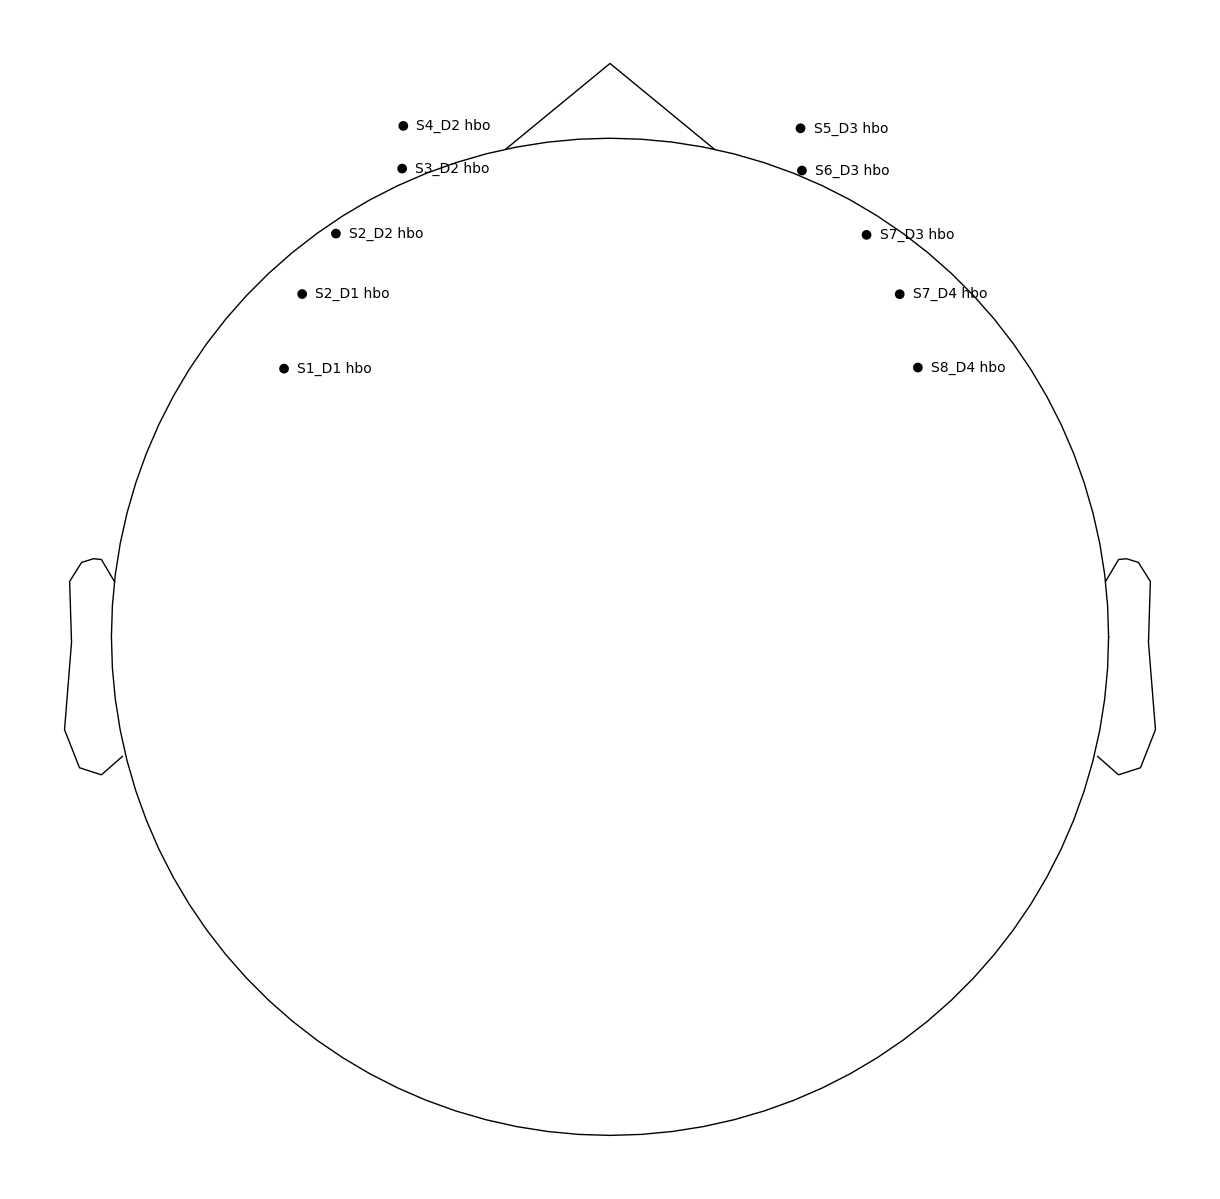

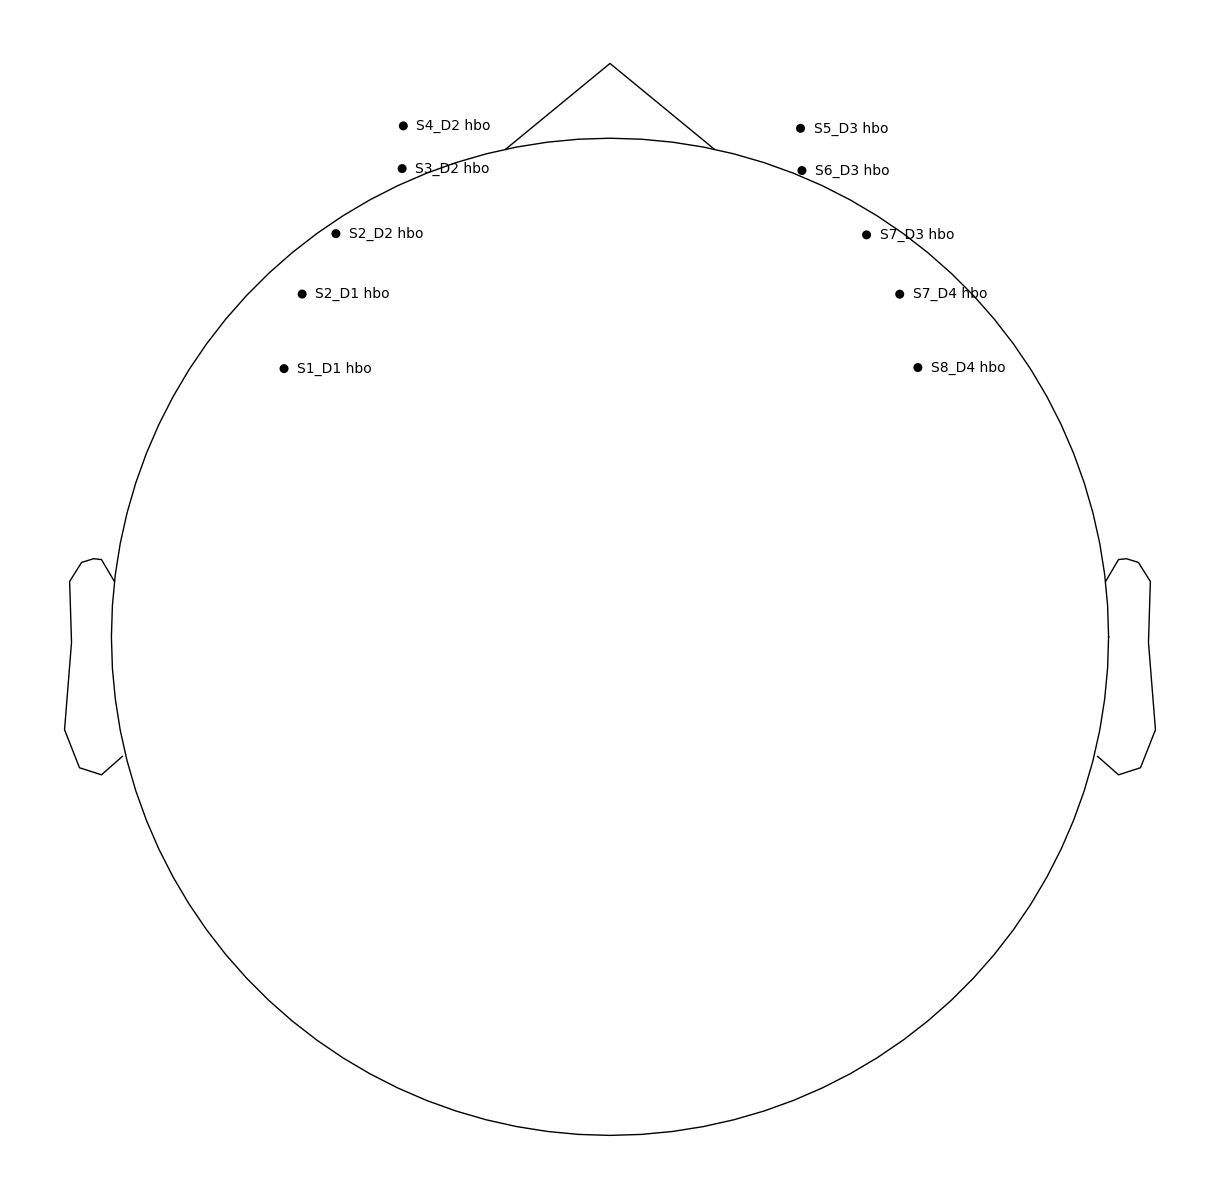

In [1164]:
scan.get_montage().plot()